# <font style="color:blue">Training with Regularization</font>

We have already covered the theory of bias, variance, and different regularization techniques. 

In this notebook, we will see how to use these concepts to improve our model. We will use
1. Batch-Norm
2. Dropout
3. Data augmentation

We will use the "Fashion MNIST" dataset, and `LambdaLR` scheduler with `SGD` to illustrate different regularization techniques.

**We will do the following Experiments:**

1. **Experiment with a Small Model:** We will start with a Small CNN (**`SmallModel` \[S\]**), which reaches an accuracy of around 90%. We will notice that even training accuracy is not very high.  It means that LeNet model is not complex enough to overfit (get almost 100% accuracy on training data or around zero loss on training data). By definition of bias and variance, this model has high bias and high variance. 
1. **Experiment with a Larger Model:** So, we will use a deeper and wider model. We will create one bigger model (**`MediumModel` \[M\]**). Also, to accomplish our different set of experiments, we will create a configurable model where we can specify options for Dropout/Batch Norm etc.
1. **Experiment without any Regularization:** First, we will try the `MediumModel` without any regularization (no dropout or batch norm or data augmentation or L2 penalty). We will see that that model is overfitted (around 100 % training accuracy but 92-93 % validation accuracy). This model has low bias and high variance. Hence, the model has a high variance; we need one or more regularization techniques to reduce this high variance.
1. **Experiment with Batch Normalization:** We will start with batch-norm regularization. We will notice that accuracy improved slightly. We will also notice that loss decreased. Even if accuracy is the same but loss decreases, it means this is a more robust model (misclassification confidence will not be very high).
1. **Experiment with Dropout Regularization:** We will explore dropout without batch-norm. We will notice that dropout is almost the same in terms of accuracy but better in terms of loss.
1. **Experiment to combine Dropout and Batch Norm:** After dropout, we will see batch-norm with dropout. It turns out to be slightly better than both above in terms of accuracy and loss.
1. **Experiment with Data Augmentation:** Then we will explore the data augmentation technique for regularization. We will start with data augmentation without batch-norm and dropout. Alone data augmentation turns out to be better than all the above techniques. Why is it so? Because it is a virtual way to increase the number of training data, which helps model in generalization. 
1. **Experiment with all three techniques:** After the above experiment, we will use batch-norm and dropout both with data augmentation. It turns out to be better than all the above. At the same time, we will notice that train loss is decreasing until the last epoch (60 epoch) and higher than validation loss, although validation loss is not decreasing. It means there no point in increasing the total number of epochs because most probably, validation loss will not decrease. 
1. **Experiment with an even Larger Model:** After the above experiment, we will create one more complex model (**LargeModel \[L\]**, by increasing the number of filters) and will explore data augmentation with batch-norm and dropout. It turns out to be a better model than all the above.



# <font style="color:blue">1. Training Utils</font>

In [7]:
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt  # one of the best graphics library for python
plt.style.use('ggplot')

In [9]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler

## <font style="color:green">1.1. Fashion MNIST Data with optional Data Augmentation</font>

We are already familiar with the `get_data` method. We have modified this method to generate augmented data if specified using the `data_augmentation` argument.

For Data Augmentation, we perform the following:
- Random Horizontal Flip
- Random Vertical Flip
- Random Rotation

In [10]:
def get_data(batch_size, data_root='data', num_workers=1, data_augmentation=False):
    
    # common transforms
    common_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860, ), (0.3530, ))
    ])
    
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:
        train_transforms = transforms.Compose([
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(20, fill=(0,)),
                transforms.RandomCrop(28, padding=4)
            ]),
            transforms.ToTensor(),
            transforms.Normalize((0.2860, ), (0.3530, ))
        ])
    # else do common transforms
    else:
        train_transforms = common_transforms
        
        
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=True, transform=train_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=True, transform=common_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

## <font style="color:green">1.2. System Configuration</font>

In [11]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

## <font style="color:green">1.3. Training Configuration</font>

In [12]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  
    epochs_count: int = 60
    init_learning_rate: float = 0.02  # initial learning rate for lr scheduler
    decay_rate: float = 0.1  
    log_interval: int = 500  
    test_interval: int = 1  
    data_root: str = "./data" 
    num_workers: int = 10  
    device: str = 'cuda'  
    


## <font style="color:green">1.4. System Setup</font>

In [13]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:green">1.5. Training Function</font>

We are familiar with the training pipeline used in PyTorch.

In [14]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mode
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (it is mandatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

#         if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
#             print(
#                 'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
#                     epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
#                 )
#             )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} Train Loss: {:.6f} Acc: {:.4f}'.format(
                epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

## <font style="color:green">1.6. Validation Function</font>

In [15]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

## <font style="color:green">1.7. Main Function for Training and Validation</font>

In this section of code, we use the configuration parameters defined above and start the training. Here are the important actions being taken in the code below:

1. Set up system parameters like CPU/GPU, number of threads etc.
1. Load the data using dataloaders.
1. For each epoch, call train function, and for every test interval, call validation function.
1. Do `scheduler.step()` to update learning rate for next epoch.
1. Set up variables to track loss and accuracy and start training.



In [16]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=False):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
        
        # scheduler step/ update learning rate
        if scheduler is not None:
            scheduler.step()
        
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:green">1.8. Optimizer and Scheduler</font>

Let's write optimizer and scheduler as a method because we have to use it in all training experiments. 

In [17]:
def get_optimizer_and_scheduler(model):
    train_config = TrainingConfiguration()

    init_learning_rate = train_config.init_learning_rate

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr = init_learning_rate,
        momentum = 0.9
    )

    decay_rate = train_config.decay_rate

    lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

    # Scheduler
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)
    
    return optimizer, scheduler
    


## <font style="color:green">1.9. Plot Loss and Accuracy</font>

In [38]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors, model_sizes, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=15,
                       fig_size=(16, 8), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="[{2}] TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i], model_sizes[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="[{2}] VALID ({0:.4}): {1}".format(min_val_loss, labels[i], model_sizes[i]))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="[{2}] TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i], model_sizes[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="[{2}] VALID ({0:.4}): {1}".format(max_val_acc, labels[i], model_sizes[i]))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')
    
    plt.show()
    
    return   

# <font style="color:blue">2. Model 1: Small Model [S]</font>
This is a smaller model as compared to the LeNet Network we saw earlier. Let us see how much it learns!

In [19]:
class SmallModel(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            
            nn.Linear(in_features=8 * 5 * 5, out_features=100), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=100, out_features=50), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=50, out_features=10)
        )

    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

## <font style="color:green">2.1. Experiment 1: Without Regularization [S]</font>

In [ ]:
model = SmallModel()
print(model)

# get optimizer and scheduler
optimizer, scheduler = get_optimizer_and_scheduler(model)

# train and validate
model, train_loss_exp1, train_acc_exp1, val_loss_exp1, val_acc_exp1 = main(model, 
                                                                           optimizer, 
                                                                           scheduler)



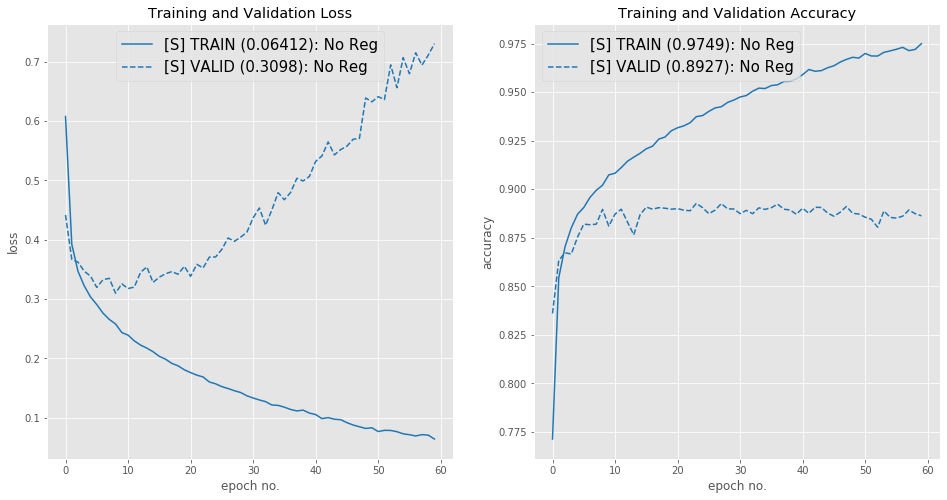

In [48]:
plot_loss_accuracy(train_loss=[train_loss_exp1], 
                   val_loss=[val_loss_exp1], 
                   train_acc=[train_acc_exp1], 
                   val_acc=[val_acc_exp1], 
                   labels=['No Reg'], 
                   colors=['blue'], 
                   model_sizes=['S'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

We can see that it has almost reached its learning capacity and it starts overfitting as we keep training it.

# <font style="color:blue">3. Model 2: Medium Model [M]</font>

This is a larger model `MediumModel`. We can specify whether we want to use `dropout` or `batch-norm` or both. We will use this network to see the effects of overfitting and regularization.

In [ ]:
class MediumModel(nn.Module):
    def __init__(self, dropout=0.0, batch_norm=False):
        super().__init__()

        # convolution layers
        if batch_norm:
            self._body = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
                nn.BatchNorm2d(16),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout(dropout)
            )
        else:
             self._body = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout(dropout)
            )
            
        
        # Fully connected layers
        self._head = nn.Sequential(
            
            nn.Linear(in_features=64 * 4 * 4, out_features=512), 
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(in_features=512, out_features=128), 
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

## <font style="color:green">3.1. Experiment 2: Without Regularization [M]</font>

In [ ]:
model = MediumModel()
print(model)

# get optimizer and scheduler
optimizer, scheduler = get_optimizer_and_scheduler(model)

# train and validate
model, train_loss_exp2, train_acc_exp2, val_loss_exp2, val_acc_exp2 = main(model, 
                                                                           optimizer, 
                                                                           scheduler)

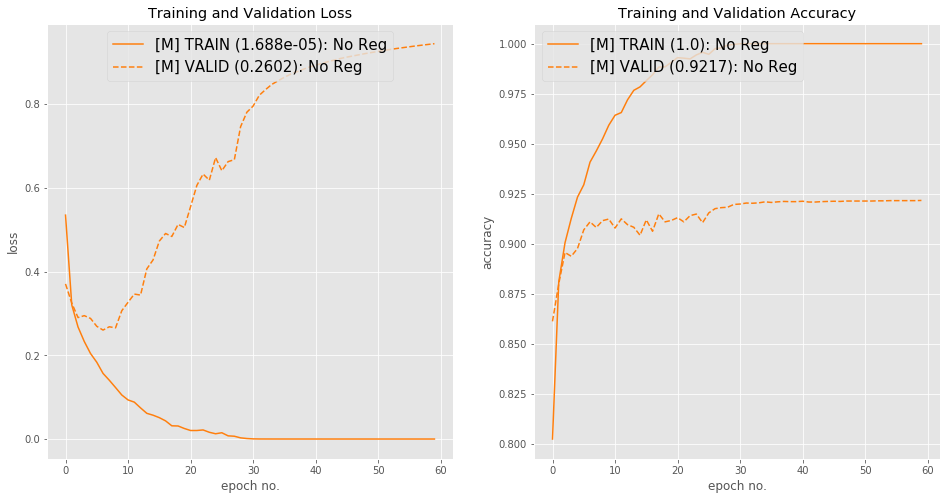

In [47]:
plot_loss_accuracy(train_loss=[train_loss_exp2], 
                   val_loss=[val_loss_exp2], 
                   train_acc=[train_acc_exp2], 
                   val_acc=[val_acc_exp2], 
                   labels=['No Reg'], 
                   colors=['orange'], 
                   model_sizes=['M'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

Here, we can see that the network has reached a training accuracy of 1 and a training loss of almost 0. This means that the network has the capacity but we can also see that the validation loss and accuracy are not close to the training loss and accuracy. This means that the model is trying to memorize the training data. We need to rectify this using the regularization techniques we have learnt so far.

## <font style="color:green">3.2. Experiment 3: With Batch-Norm [M]</font>
We have already seen batch norm earlier. Let us see if it can help reduce overfitting. We will add batch normalization to the network and train it.

In [ ]:
model = MediumModel(batch_norm=True)
print(model)

optimizer, scheduler = get_optimizer_and_scheduler(model)

model, train_loss_exp3, train_acc_exp3, val_loss_exp3, val_acc_exp3 = main(model, 
                                                                           optimizer, 
                                                                           scheduler)

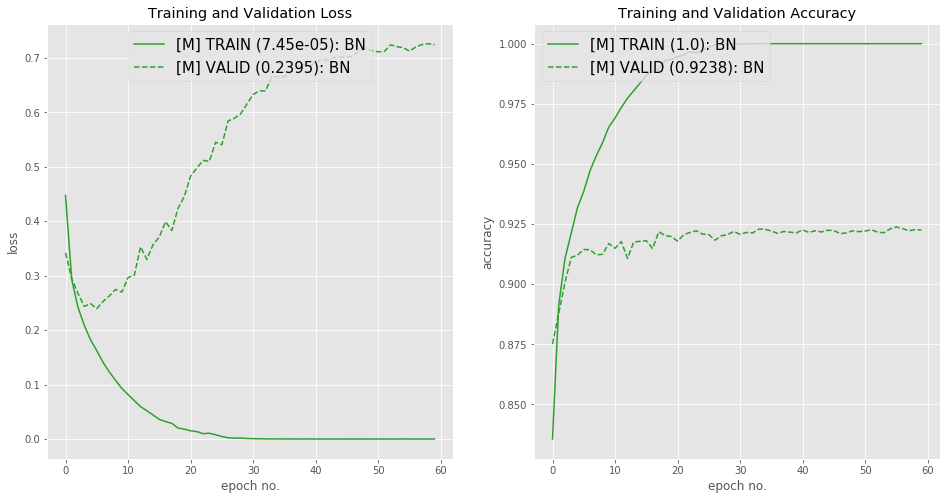

In [46]:
plot_loss_accuracy(train_loss=[train_loss_exp3], 
                   val_loss=[val_loss_exp3], 
                   train_acc=[train_acc_exp3], 
                   val_acc=[val_acc_exp3], 
                   labels=['BN'], 
                   colors=['green'], 
                   model_sizes=['M'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

## <font style="color:green">3.3 Experiment 4: With Dropout [M]</font>
Let us add Dropout Regularization. We will add a dropout layers with p=0.25.

In [ ]:
model = MediumModel(0.25)
print(model)

optimizer, scheduler = get_optimizer_and_scheduler(model)

model, train_loss_exp4, train_acc_exp4, val_loss_exp4, val_acc_exp4 = main(model, 
                                                                           optimizer, 
                                                                           scheduler)

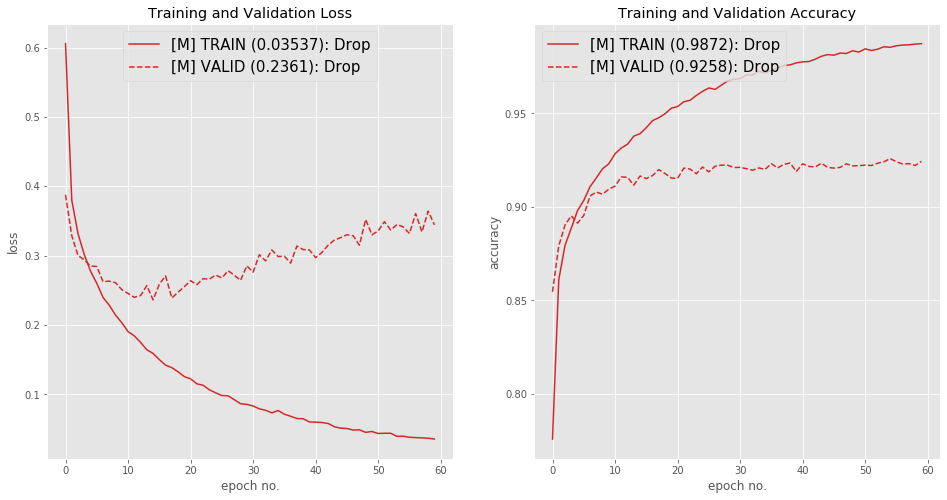

In [45]:
plot_loss_accuracy(train_loss=[train_loss_exp4], 
                   val_loss=[val_loss_exp4], 
                   train_acc=[train_acc_exp4], 
                   val_acc=[val_acc_exp4], 
                   labels=['Drop'], 
                   colors=['red'], 
                   model_sizes=['M'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

We can see that the addition of dropout has substantial effect on the validation curves as compared to Batchnorm. This can be thought of as training the network on missing data. So, it learns more robust features.

## <font style="color:green">3.4. Experiment 5: With Batch-Norm and Dropout [M]</font>
Let us see the effect of batch norm and Dropout together.

In [ ]:
model = MediumModel(0.25, batch_norm=True)
print(model)

optimizer, scheduler = get_optimizer_and_scheduler(model)

model, train_loss_exp5, train_acc_exp5, val_loss_exp5, val_acc_exp5 = main(model, 
                                                                           optimizer, 
                                                                           scheduler)

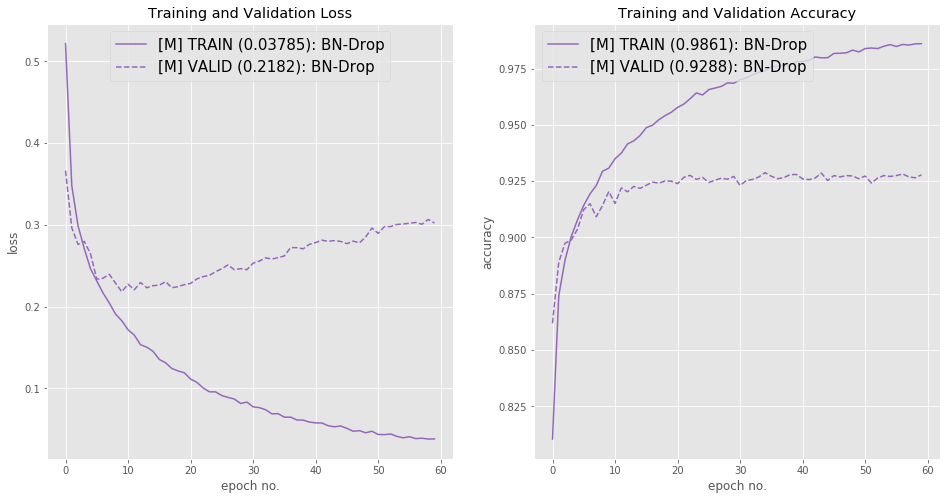

In [44]:
plot_loss_accuracy(train_loss=[train_loss_exp5], 
                   val_loss=[val_loss_exp5], 
                   train_acc=[train_acc_exp5], 
                   val_acc=[val_acc_exp5], 
                   labels=['BN-Drop'], 
                   colors=['purple'], 
                   model_sizes=['M'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

There is a mild improvement if we add both. However, it can be tricky and you should always check with both separately.

## <font style="color:green">3.5. Experiment 6: Data Augmentation [M]</font>
Finally, we would like to add data augmentation as a regularization step. This should have substantial effect on the validation curves since we are actually training it on more data.

**NOTE:** Data augmentation is not added to the network like we did for the other two techniques. It is a method of increasing the data while training by creating transformations out of the original data. Thus, we will use the `get_data` function to add data_augmentation. We pass the required argument to the function and the data passed to the training routine is generated using data augmentation. Do check out the code to see what types of augmentation we are doing.

In [ ]:
model = MediumModel()
print(model)

optimizer, scheduler = get_optimizer_and_scheduler(model)

model, train_loss_exp6, train_acc_exp6, val_loss_exp6, val_acc_exp6 = main(model, 
                                                                           optimizer, 
                                                                           scheduler, 
                                                                           data_augmentation=True)

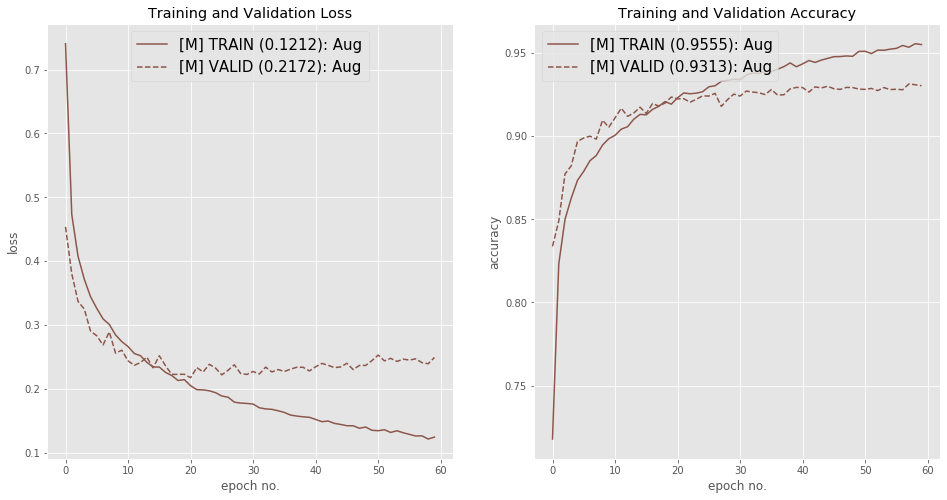

In [43]:
plot_loss_accuracy(train_loss=[train_loss_exp6], 
                   val_loss=[val_loss_exp6], 
                   train_acc=[train_acc_exp6], 
                   val_acc=[val_acc_exp6], 
                   labels=['Aug'], 
                   colors=['brown'], 
                   model_sizes=['M'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

You can see that there is a huge improvement in validation loss and accuracy.

## <font style="color:green">3.6. Experiment 7: Data Augmentation with Batch-Norm and Dropout [M]</font>
Why stop at Data Augmentation? Let us add droupout as well as Batch Norm to the pipeline and make it more robust!

In [ ]:
model = MediumModel(0.25, batch_norm=True)
print(model)

optimizer, scheduler = get_optimizer_and_scheduler(model)

model, train_loss_exp7, train_acc_exp7, val_loss_exp7, val_acc_exp7 = main(model, 
                                                                           optimizer, 
                                                                           scheduler, 
                                                                           data_augmentation=True)

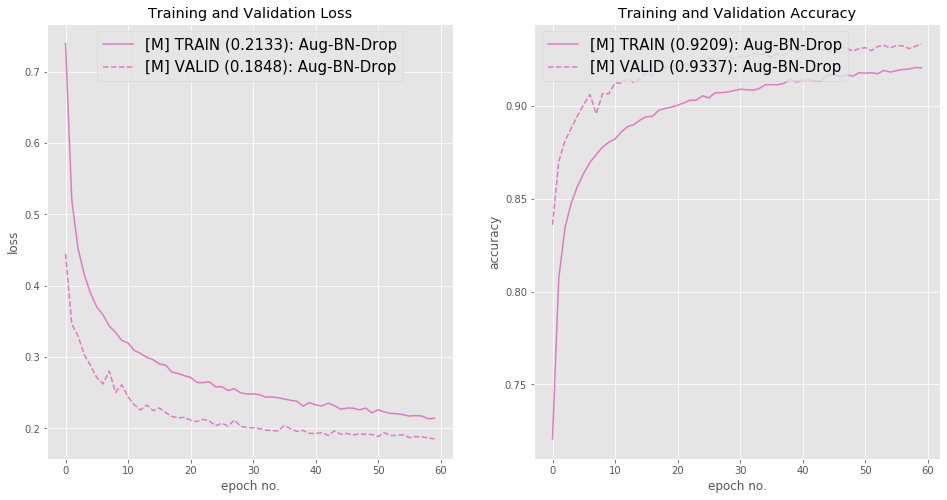

In [42]:
plot_loss_accuracy(train_loss=[train_loss_exp7], 
                   val_loss=[val_loss_exp7], 
                   train_acc=[train_acc_exp7], 
                   val_acc=[val_acc_exp7], 
                   labels=['Aug-BN-Drop'], 
                   colors=['pink'], 
                   model_sizes=['M'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

# <font style="color:blue">4. Model 3: Large Model [L]</font>
As a final step, let's take a larger model and see if we can improve the metrics even further.

In [ ]:
class LargeModel(nn.Module):
    def __init__(self, dropout=0.0, batch_norm=False):
        super().__init__()

        # convolution layers
        if batch_norm:
            self._body = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout(dropout)
            )
        else:
            self._body = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout(dropout)
            )
            
        
        # Fully connected layers
        self._head = nn.Sequential(
            
            nn.Linear(in_features=128 * 7 * 7, out_features=2048), 
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(in_features=2048, out_features=256), 
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(in_features=256, out_features=10)
        )

    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

## <font style="color:green">4.1. Experiment 8: Data Augmentation with Batch-Norm and Dropout [L]</font>

In [ ]:
model = LargeModel(0.25, batch_norm=True)
print(model)

optimizer, scheduler = get_optimizer_and_scheduler(model)

model, train_loss_exp8, train_acc_exp8, val_loss_exp8, val_acc_exp8 = main(model, 
                                                                               optimizer, 
                                                                               scheduler, 
                                                                               data_augmentation=True)

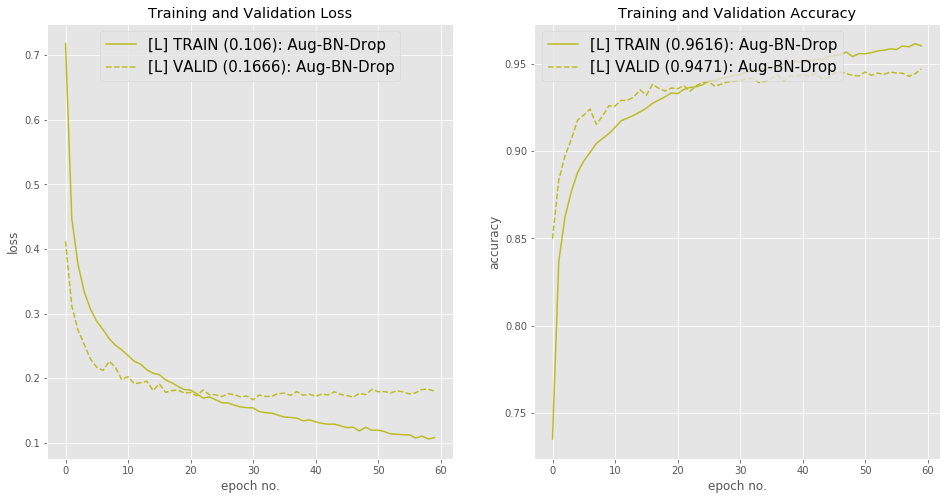

In [41]:
plot_loss_accuracy(train_loss=[train_loss_exp8], 
                   val_loss=[val_loss_exp8], 
                   train_acc=[train_acc_exp8], 
                   val_acc=[val_acc_exp8], 
                   labels=['Aug-BN-Drop'], 
                   colors=['olive'], 
                   model_sizes=['L'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

# <font style="color:blue">5. Loss and Accuracy Plot of all Experiments.</font>

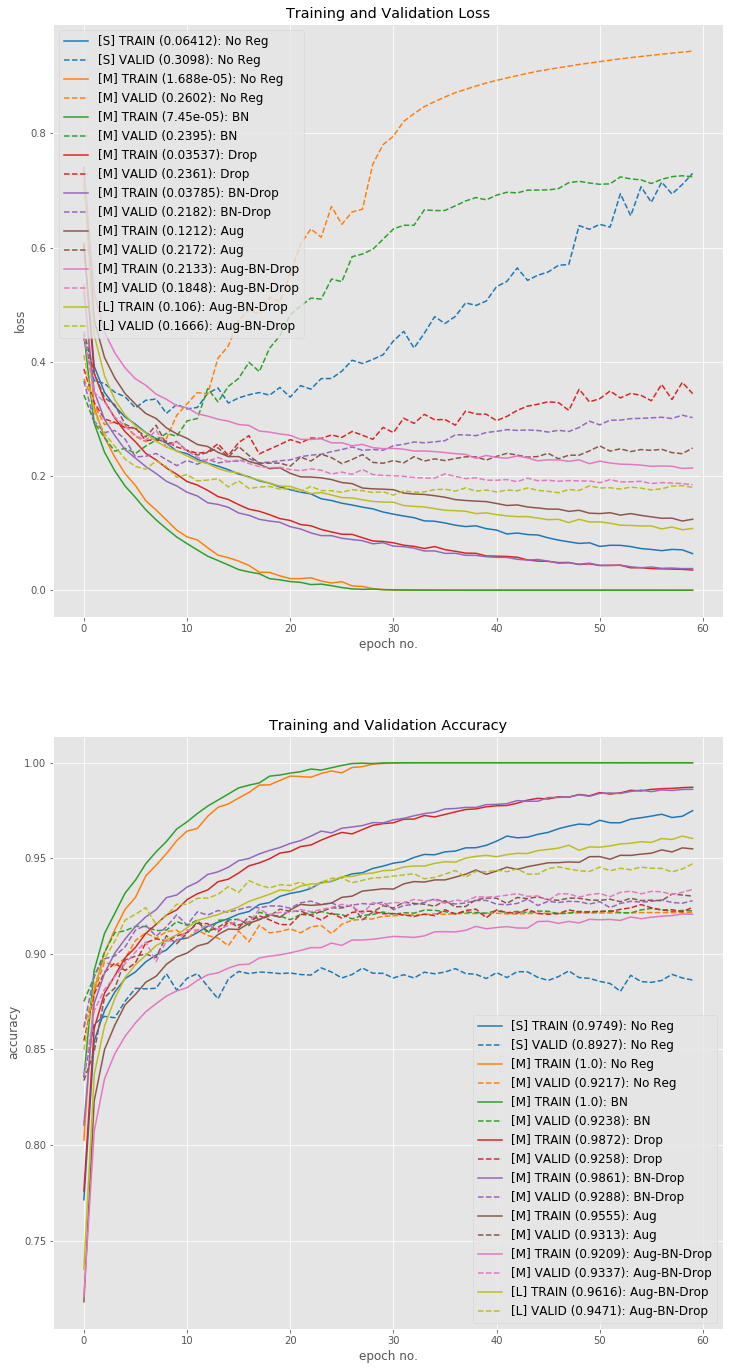

In [40]:
plot_loss_accuracy(train_loss=[train_loss_exp1, train_loss_exp2, train_loss_exp3, train_loss_exp4, 
                               train_loss_exp5, train_loss_exp6, train_loss_exp7, train_loss_exp8], 
                   val_loss=[val_loss_exp1, val_loss_exp2, val_loss_exp3, val_loss_exp4,
                             val_loss_exp5, val_loss_exp6, val_loss_exp7, val_loss_exp8], 
                   train_acc=[train_acc_exp1, train_acc_exp2, train_acc_exp3, train_acc_exp4, 
                              train_acc_exp5, train_acc_exp6, train_acc_exp7, train_acc_exp8], 
                   val_acc=[val_acc_exp1, val_acc_exp2, val_acc_exp3, val_acc_exp4, 
                            val_acc_exp5, val_acc_exp6, val_acc_exp7, val_acc_exp8], 
                   labels=['No Reg', 'No Reg', 'BN', 'Drop', 'BN-Drop', 'Aug', 'Aug-BN-Drop', 'Aug-BN-Drop'], 
                   colors=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'olive'], 
                   model_sizes=['S', 'M', 'M', 'M', 'M', 'M', 'M', 'L'], 
                   loss_legend_loc='upper left', 
                   acc_legend_loc='best', 
                   legend_font = 12,
                   fig_size=(12, 24), 
                   sub_plot1=(2, 1, 1), 
                   sub_plot2=(2, 1, 2))

# <font style="color:blue">6. Conclusion.</font>

Start with a simple model which overfits the training data. 

Then use different regularization techniques and different optimizers and schedulers. 

If results are not satisfactory, change the model and experiment again. 

# <font style="color:blue">Exercise</font>
1. Try with different dropout values, plot curves and get more insights as to what happens.
1. Add more transforms to data augmentation [Check the complete list](https://pytorch.org/docs/stable/torchvision/transforms.html).
1. Change the dataset to STL ( `torchvision.datasets.STL` ) and see the results (Note that you need to change the network accordingly).